# Predicting Agua Potabilization

Data source: 
- Training: water_test.csv
- Testing: water_train.csv

Predicting: 0 no potable, 1 potable

## 1. Prepare environment

In [1]:
# Importing libraries
import expectexception
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from environment import prepare_environment

from typing import List, Tuple
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

In [2]:
# Global variables
# global variables
SEED = 42

DATASET_FILE_WATER_POTABILITY_TRAIN = 'data-sources/water_train.csv'
DATASET_FILE_WATER_POTABILITY_TEST = 'data-sources/water_test.csv'

In [3]:
# Check if your GPU driver and CUDA is enabled and accessible by PyTorch
torch.cuda.is_available()

True

In [4]:
# Global configuration
prepare_environment()

torch.set_printoptions(precision=10)

# Reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)

### Utilities

In [5]:
class CSVDataSet(Dataset):
    """
    PyTorch Dataset extended to load the data based on a given CSV file
    Assumptions:
    - Only CSV files can be imported.
    - All columns in the CSV file are included unless the `cols_to_include` list is defined. 
      In that case only the columns' name included in the list are considered.
    - The last column of the loaded dataset is the target/label column.
    """
    
    def __init__(self, csv_path:str, cols_to_include:List['str'] = None) -> None:
        super().__init__
        data = pd.read_csv(csv_path)
        if cols_to_include:
            data = data[cols_to_include]
        self.data = data.to_numpy()

    def __len__(self) -> int:
        return self.data.shape[0]

    def __getitem__(self, idx:int) -> Tuple[np.ndarray, np.ndarray]:
        features = self.data[idx, :-1]
        label = self.data[idx, -1]
        return features, label

In [6]:
# Build the binary classifier model
class WaterModel(nn.Module):
    """Improved model for binary classifier problems with a solution to
    exploding gradients problems.
    """
    def __init__(self, seed:int=SEED) -> None:
        super().__init__()
        
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = x.float()
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x.double()

## 2. Get dataloader

In [7]:
# Get the dataset
dataset_train = CSVDataSet(DATASET_FILE_WATER_POTABILITY_TRAIN)
dataset_test = CSVDataSet(DATASET_FILE_WATER_POTABILITY_TEST)
print(f"""
Train dataset size: {len(dataset_train)}
Test dataset size: {len(dataset_test)}
""")

# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(dataset_train, batch_size=200, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=200, shuffle=True)


Train dataset size: 1508
Test dataset size: 503



## 3. Build the model

In [8]:
# Build the model
model = WaterModel()
print(model)

# Set the criterion and teh optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Create accuracy metric
accuracy = Accuracy(task="multiclass", num_classes=2)

WaterModel(
  (fc1): Linear(in_features=9, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)


## 4. Train the model

In [9]:
# Train the model
losses = []
accuracies = []
epochs = int(1e3)
model.train()
for epoch in range(epochs):
    for X, y in dataloader_train:                   # Get feature and target from the data loader
        optimizer.zero_grad()                       # zero the parameter gradients
        y_out = model(X)                            # Run a forward pass
        y_pred = (y_out >= 0.5).float()             # threading = 0.5
        loss = criterion(y_out, y.view(-1, 1))      # Compute loss
        loss.backward()                             # Backward pass
        optimizer.step()                            # Optimization
        accuracy(y_pred, y.view(-1, 1))             # Calculate accuracy

    accuracies.append(accuracy.compute())           # Record the epoch accuracy
    accuracy.reset()                                # Reset the metric for the next epoch 
    losses.append(loss.item())                      # Record the loss per epoch
    
    if (epoch + 1) % 100 == 0:                      # Print the loss every 100 epochs
        print(f'Epoch [{epoch+1}], Loss: {loss.item():.6f}, Accuracy: {accuracies[-1]:.6f}')

Epoch [100], Loss: 0.670139, Accuracy: 0.597480
Epoch [200], Loss: 0.642792, Accuracy: 0.613395
Epoch [300], Loss: 0.657562, Accuracy: 0.688992
Epoch [400], Loss: 0.532187, Accuracy: 0.703581
Epoch [500], Loss: 0.531636, Accuracy: 0.704244
Epoch [600], Loss: 0.622851, Accuracy: 0.708886
Epoch [700], Loss: 0.568929, Accuracy: 0.707560
Epoch [800], Loss: 0.584961, Accuracy: 0.708223
Epoch [900], Loss: 0.549933, Accuracy: 0.711538
Epoch [1000], Loss: 0.544126, Accuracy: 0.720822


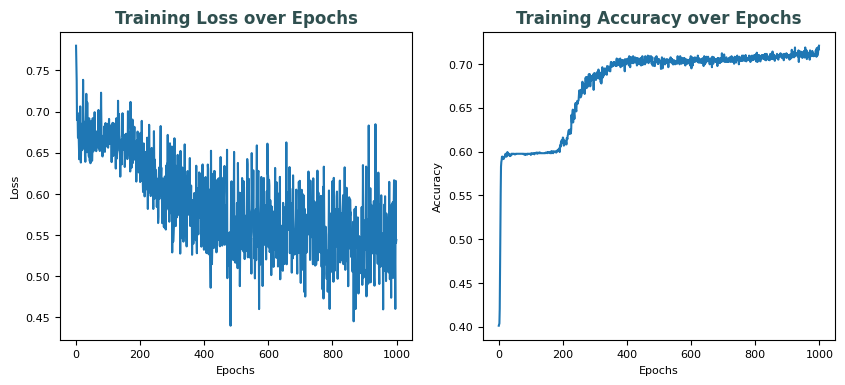

In [10]:
# Visualizing the loss and accuracy in training set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(range(epochs), losses)
ax1.set_title("Training Loss over Epochs")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(range(epochs), accuracies)
ax2.set_title("Training Accuracy over Epochs")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
plt.show()

## 5. Evaluate model

In [11]:
# Evaluate the model
model.eval()
with torch.no_grad():
    for X, y in dataloader_test:
        y_out = model(X)
        y_pred = (y_out >= 0.5).float()
        accuracy(y_pred, y.view(-1, 1))

# Compute total test accuracy
testing_accuracy = accuracy.compute()
accuracy.reset()
print(f"Test Accuracy: {testing_accuracy}")

Test Accuracy: 0.6838966012001038


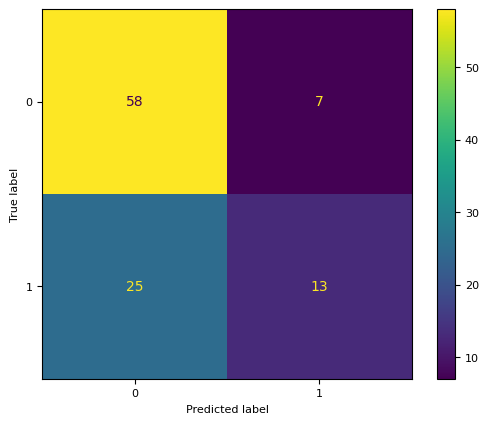

In [12]:
cm = confusion_matrix(y.numpy().flatten(), 
                      y_pred.numpy().flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
_ = disp.plot()

In [13]:
pd.DataFrame({
    'y_true': y.numpy().flatten(),
    'y_pred': y_pred.numpy().flatten(),
    'Accerted': ['True' 
                 if y.numpy().flatten()[i] == y_pred.numpy().flatten()[i]
                 else ''
                 for i in range(len(y))] 
})

,y_true,y_pred,Accerted
0,0.0,0.0,True
1,0.0,0.0,True
2,0.0,0.0,True
3,0.0,0.0,True
4,1.0,1.0,True
...,...,...,...
98,0.0,0.0,True
99,1.0,1.0,True
100,0.0,0.0,True
101,0.0,0.0,True


----------------------------------